In [1]:
# !pip install roboflow supervision
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
from roboflow import Roboflow
import supervision as sv
import cv2
import numpy as np
from typing import List
import matplotlib.pyplot as plt


rf = Roboflow(api_key="4gI0eIbggGqzYmHFPYIk")
project = rf.workspace().project("waste-in-water")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In [5]:
path = "../data/Dataset/test/"
filename = "test_image100"

result = model.predict(path+filename+".JPG", confidence=20, overlap=30).json()

In [ ]:
import json
from create_feature_vectors import Rectangle

# get trash labeled rectangles from json file
true_rectangles = []

with open(path + filename + ".json") as json_file:
    data = json.load(json_file)
    shapes = data["shapes"]

    for shape in shapes:
        if shape["shape_type"] != "rectangle":
            raise Exception("Invalid shape type in", filename)
        if shape["label"] != "trash":
            raise Exception("Invalid label in", filename)

        p1, p2 = shape["points"]
        p1 = tuple(map(int, p1))
        p2 = tuple(map(int, p2))
        print(p1, p2)
        
        true_rectangles.append(Rectangle(x_l=min(p1[0], p2[0]), y_b=min(p1[1], p2[1]), x_r=max(p1[0], p2[0]), y_t=max(p1[1], p2[1])))
        # true_rectangles.append(Rectangle(x_l=bl[0], y_b=bl[1], x_r=tr[0], y_t=tr[1]))


# get predicted rectangles from the result
predicted_rectangles = []
predicted_confidences = []

for item in result["predictions"]:
    if item["class"] != "Plastic Bottle":
        print(f"Detected other object: {item['class']}")
    else:
        predicted_rectangles.append(Rectangle(x_l=item["x"], y_b=item["y"], x_r=item["x"]+item["width"], y_t=item["y"]+item["height"]))
        predicted_confidences.append(item["confidence"])

(1513, 333) (1384, 500)


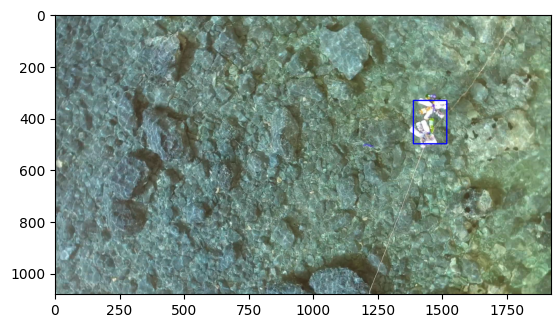

In [ ]:
def draw_rectangles(image, rectangles: List[Rectangle], color=(0, 255, 0)):
    for rectangle in rectangles:
        cv2.rectangle(
            image,
            (rectangle.x_l, rectangle.y_b),
            (rectangle.x_r, rectangle.y_t),
            color,
            3,
        )
    return image

image = cv2.imread(path + filename + ".JPG")
# image = draw_rectangles(image, predicted_rectangles, color=(0, 255, 0))
# image = draw_rectangles(image, merged_rectangles[0], color=(255, 0, 0))
image = draw_rectangles(image, true_rectangles, color=(0, 0, 255))

plt.imshow(image)


In [ ]:
def iou_rectangles(rect1: Rectangle, rect2: Rectangle):
    x_left = max(rect1.x_l, rect2.x_l)
    x_right = min(rect1.x_r, rect2.x_r)
    y_bottom = max(rect1.y_b, rect2.y_b)
    y_top = min(rect1.y_t, rect2.y_t)

    intersection = max(0, x_right - x_left) * max(0, y_top - y_bottom)

    area1 = (rect1.x_r - rect1.x_l) * (rect1.y_t - rect1.y_b)
    area2 = (rect2.x_r - rect2.x_l) * (rect2.y_t - rect2.y_b)

    union = area1 + area2 - intersection
    return intersection / union

In [ ]:
def calculate_ap50(true_rectangles, predicted_rectangles, predicted_confidences, iou_threshold=0.5):
    """
    Calculate the precision for a given IoU threshold. Rectangles should be from the same class.
    @param true_rectangles: List of true rectangles
    @param predicted_rectangles: List of predicted rectangles
    @param predicted_confidences: List of predicted confidences
    @param iou_threshold: IoU threshold
    """

    # Sort predicted rectangles by confidence score
    sorted_indices = np.argsort(predicted_confidences)[::-1]
    predicted_rectangles = [predicted_rectangles[i] for i in sorted_indices]
    print(f"{predicted_rectangles=}")

    total_true_rectangles = len(true_rectangles)
    true_positives = np.zeros(len(predicted_rectangles))
    false_positives = np.zeros(len(predicted_rectangles))

    for d, pred_rect in enumerate(predicted_rectangles):
        for t, true_rect in enumerate(true_rectangles):
            iou = iou_rectangles(pred_rect, true_rect)
            print(f"{iou=}")
            if iou >= iou_threshold and not true_positives[d]:
                true_positives[d] = 1
            else:
                false_positives[d] = 1

    cumulative_true_positives = np.cumsum(true_positives)
    cumulative_false_positives = np.cumsum(false_positives)
    precision = cumulative_true_positives / (cumulative_true_positives + cumulative_false_positives)
    # recall = cumulative_true_positives / total_true_rectangles

    return precision

ap50 = calculate_ap50(true_rectangles, merged_rectangles[0], merged_rectangles[1], iou_threshold=0.5)
ap50

NameError: name 'merged_rectangles' is not defined

SupervisionWarnings: from_roboflow is deprecated: `Detections.from_roboflow` is deprecated and will be removed in `supervision-0.22.0`. Use `Detections.from_inference` instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


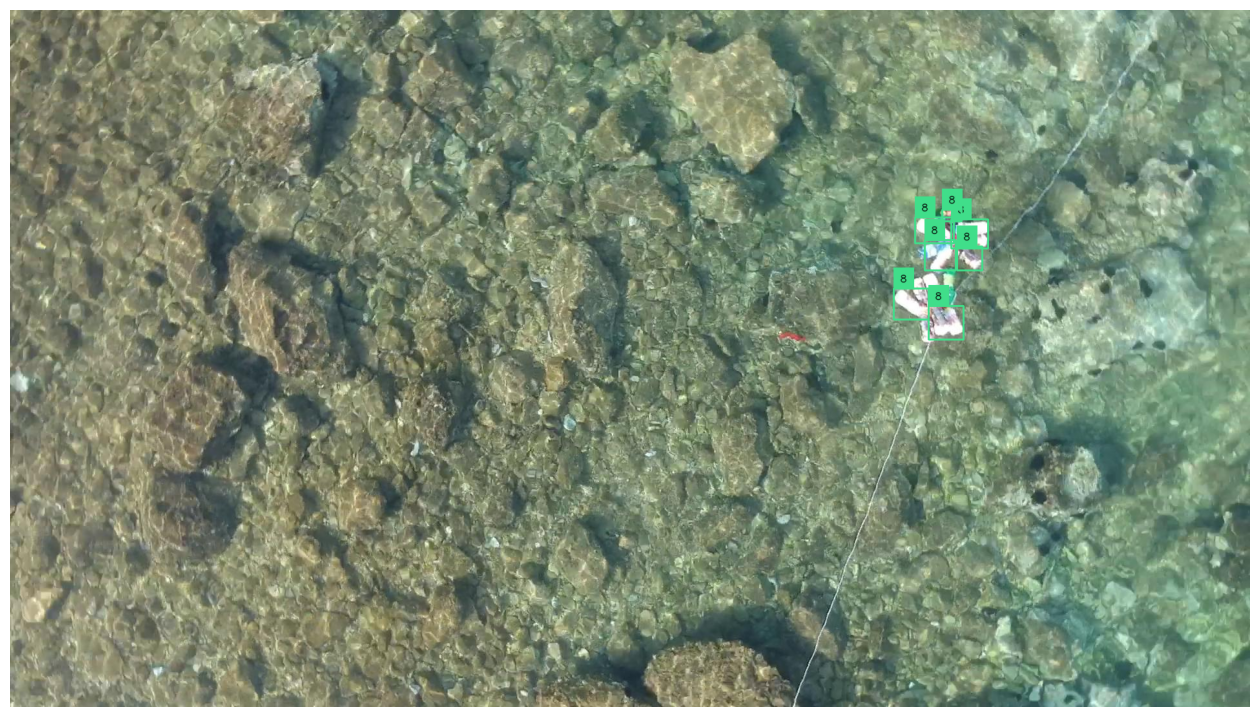

In [ ]:
# show labels and bboxes from roboflow
labels = [item["class"] for item in result["predictions"]]
detections = sv.Detections.from_roboflow(result)

label_annotator = sv.LabelAnnotator()
bounding_box_annotator = sv.BoxAnnotator()

image = cv2.imread("../data/Dataset/test/test_image100.JPG")

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
# annotated_image = label_annotator.annotate(
#     scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(16, 16))

In [ ]:
import numpy as np
predictions = list(zip(detections.xyxy, detections.confidence, detections.class_id))
predictions = np.array([(*prediction[0], prediction[1], prediction[2]) for prediction in predictions])
    

# predictions, detections
sv.box_non_max_suppression(predictions, iou_threshold=0.01)

array([ True, False, False,  True,  True,  True, False])

In [ ]:
from create_feature_vectors import Rectangle
from typing import List
import numpy as np

def rectangles_intersect(
    rect1: Rectangle,
    rect2: Rectangle,
) -> bool:

    x_distance = max(0, min(rect1.x_r, rect2.x_r) - max(rect1.x_l, rect2.x_l))
    y_distance = max(0, min(rect1.y_t, rect2.y_t) - max(rect1.y_b, rect2.y_b))
    return x_distance * y_distance > 0


def merge_rectangles(rectangles_in: list[Rectangle], confidences=None, image=None) -> List[Rectangle]:
    rectangles = rectangles_in.copy()
    changed = True
    while changed == True:
        changed = False
        i = 0
        while i < len(rectangles):
            j = i + 1
            while j < len(rectangles):
                if rectangles_intersect(rectangles[i], rectangles[j]):
                    new_rectangle = Rectangle(
                        x_l=min(rectangles[i].x_l, rectangles[j].x_l),
                        y_b=min(rectangles[i].y_b, rectangles[j].y_b),
                        x_r=max(rectangles[i].x_r, rectangles[j].x_r),
                        y_t=max(rectangles[i].y_t, rectangles[j].y_t),
                    )
                    rectangles[i] = new_rectangle
                    rectangles.pop(j)
                    
                    confidences[i] = max(confidences[i], confidences[j])
                    confidences.pop(j)
                    changed = True

                else:
                    j += 1
            i += 1
        # draw_rectangles(image, rectangles, color=(255, 0, 0))
        # plt.imshow(image)

    return rectangles, confidences



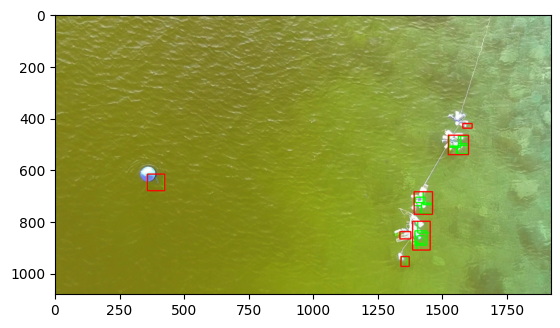

In [ ]:
predicted_rectangles = [Rectangle(x_l=1381, y_b=878, x_r=1396, y_t=910), Rectangle(x_l=1387, y_b=739, x_r=1414, y_t=772), Rectangle(x_l=1416, y_b=729, x_r=1458, y_t=769), Rectangle(x_l=1401, y_b=799, x_r=1449, y_t=844), Rectangle(x_l=1521, y_b=509, x_r=1551, y_t=542), Rectangle(x_l=1522, y_b=467, x_r=1567, y_t=514), Rectangle(x_l=1392, y_b=706, x_r=1428, y_t=727), Rectangle(x_l=1558, y_b=470, x_r=1597, y_t=500), Rectangle(x_l=1332, y_b=839, x_r=1374, y_t=867), Rectangle(x_l=1401, y_b=855, x_r=1425, y_t=885), Rectangle(x_l=357, y_b=617, x_r=423, y_t=681), Rectangle(x_l=1555, y_b=507, x_r=1594, y_t=539), Rectangle(x_l=1575, y_b=422, x_r=1611, y_t=440), Rectangle(x_l=1336, y_b=936, x_r=1363, y_t=973), Rectangle(x_l=1338, y_b=935, x_r=1368, y_t=973), Rectangle(x_l=358, y_b=617, x_r=421, y_t=681), Rectangle(x_l=1390, y_b=836, x_r=1435, y_t=891), Rectangle(x_l=1519, y_b=467, x_r=1558, y_t=514), Rectangle(x_l=1422, y_b=685, x_r=1458, y_t=735)]
image = cv2.imread("../data/Dataset/test/test_image101.JPG")
draw_rectangles(image, predicted_rectangles, color=(0, 255, 0))

predicted_confidences = [0 for _ in range(len(predicted_rectangles))]

merged_rectangles, _ = merge_rectangles(predicted_rectangles, predicted_confidences, image)
draw_rectangles(image, merged_rectangles, color=(255, 0, 0))
plt.imshow(image)
